# Time Series Analysis and Forecast on Perth Fuel Price (2022-2024)

&emsp;The project follows `Box-Jenkins`'s modelling framework that consists of `identification`, `estimation`, `model diagnostic`, and `production` to practise analysing and making forecast of a time series dataset, Perth's fuel prices.

## Table of Contents
1. [Import Library](#lib)
2. [Import Data](#data)  
&emsp;a. [SQL](#sql1)  
&emsp;b. [Pandas](#read_csv)
3. [Data Preparation](#prep)
4. [Modelling](#model)
5. [Exogenous Feature](#exog)

## Import Library<a id='lib'></a>

In [1086]:
# MySQL
import psycopg2
import mysql.connector
# Numpy and Dataframe
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Stationarity test
from statsmodels.tsa.stattools import adfuller
# Order searching
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Modelling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Save and load model
import joblib

## Import Data<a id='data'></a>
&emsp;Fuel price data was retrieved from [Fuel Watch](https://www.fuelwatch.wa.gov.au). Multiple Excel files were imported into MySQL database. Only unleaded petrol price in Perth Metro was extracted from the large amount of data for this particular analysis and forecast.

### SQL<a id='sql1'></a>

In [1087]:
# Connect database
# mydb = mysql.connector.connect(
#   host="localhost",
#   user="root",
#   password="password"
# )
# mycursor = mydb.cursor()

In [1088]:
# Extract dataset
# mycursor.execute(
#     "SELECT date, brand, price\
#     FROM base.WA_fuel\
#     WHERE (fuel = 'ULP') AND (postcode = 6000)"
# )

# result = mycursor.fetchall()

In [1089]:
# for x in result:
#     print(x)

In [1090]:
# Turn SQL result into dataframe
# df = pd.DataFrame(result, columns=['date','brand','price'])
# print(f"Number of rows: {df.shape[0]}")
# print(f"Number of columns: {df.shape[1]}")
# df.head(10)

### Pandas<a id='read_csv'></a>

In [1091]:
df = pd.read_excel('perth_fuel.xlsx').iloc[:,1:]

In [1092]:
df.drop_duplicates(inplace=True)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.reset_index(drop=True, inplace=True)
df.head(10)

Number of rows: 7028
Number of columns: 3


,date,brand,price
0,01/01/2019,Caltex,139.7
1,01/01/2019,Coles Express,142.9
2,01/01/2019,Liberty,132.4
3,02/01/2019,Caltex,136.7
4,02/01/2019,Coles Express,140.9
5,02/01/2019,Liberty,132.4
6,03/01/2019,Caltex,133.9
7,03/01/2019,Caltex,134.3
8,03/01/2019,Coles Express,138.9
9,03/01/2019,Liberty,132.4


In [1093]:
# Convert date column into datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [1094]:
df.head()

,date,brand,price
0,2019-01-01,Caltex,139.7
1,2019-01-01,Coles Express,142.9
2,2019-01-01,Liberty,132.4
3,2019-01-02,Caltex,136.7
4,2019-01-02,Coles Express,140.9


## Data Preparation<a id='prep'></a>

In [1095]:
# Congregate data using months
df['month_year'] = df['date'].dt.to_period('M')
df['date'] = df['month_year']

In [1096]:
# Group dataset by date and aggregate by price's mean
df_uni = df.groupby(['date'])['price'].agg('mean')
# Narrow down to 3 years data
df_uni = df_uni[36:]

### Stationarity

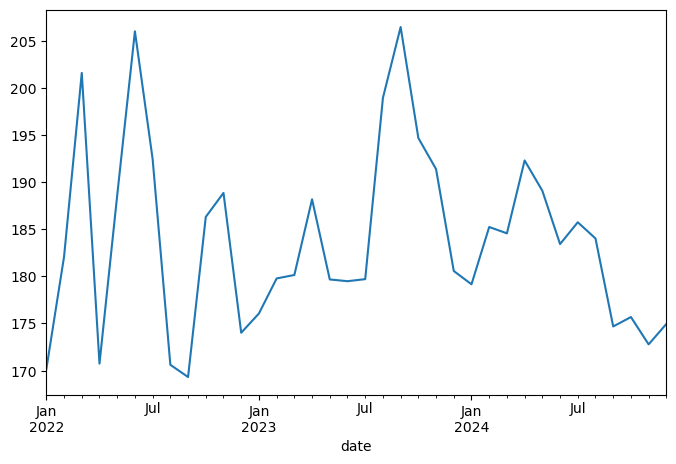

(-4.234677265656118,
 0.0005752858233488169,
 0,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 168.75827250557106)

In [1097]:
# Testing trend stationarity
fig, ax = plt.subplots(figsize=(8,5))
df_uni.plot(ax=ax)
plt.show()

adfuller(df_uni)

Without differencing, $p$ value is .0006 and the test statistic is -4.235. Thus, null hypothesis that the time series is non-stationary can be rejected.

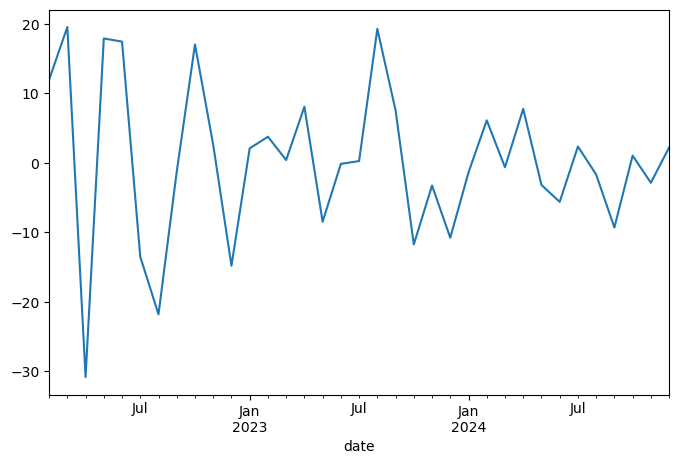

(-6.475027684774487,
 1.3377543336667251e-08,
 0,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 163.8711532980028)

In [1098]:
# Take first difference and test again
df_uni_1diff = df_uni.diff(1).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_1diff.plot(ax=ax)
plt.show()

adfuller(df_uni_1diff)

Taking first differencing makes the time series more stationary.

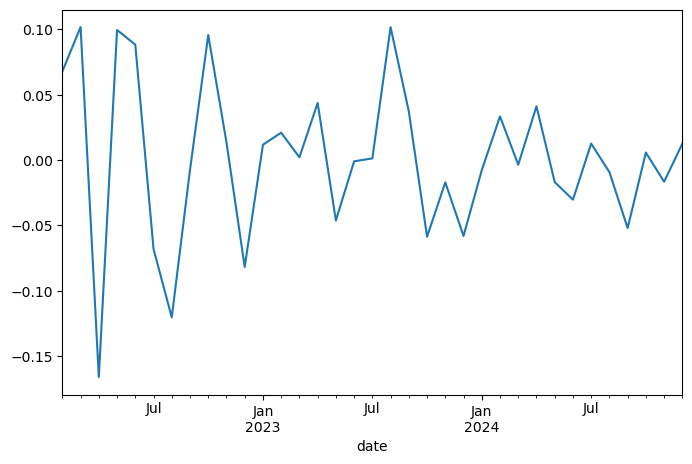

(-6.485244558881927,
 1.2656677804100626e-08,
 0,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 -87.57685500593283)

In [1099]:
# Try log-return and test again
df_uni_logreturn = np.log(df_uni/df_uni.shift(1)).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_logreturn.plot(ax=ax)
plt.show()

adfuller(df_uni_logreturn)

Log-return produces similar result. However, I will stick to the original time-series for the following analysis and forecast.

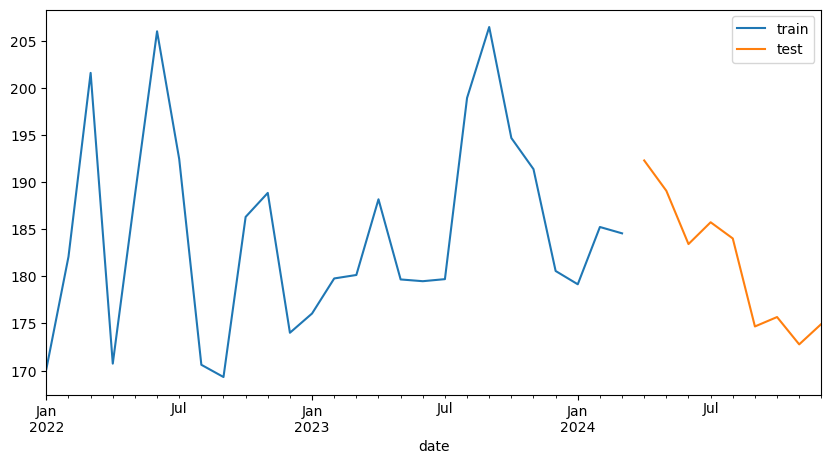

In [1100]:
# Train test split
train = df_uni.iloc[:round(df_uni.shape[0]*.75)]
test = df_uni.iloc[round(df_uni.shape[0]*.75):]

fig, ax = plt.subplots(figsize=(10,5))
train.plot(label='train', ax=ax)
test.plot(label='test', ax=ax)
plt.legend()
plt.show()

## Modelling<a id='model'></a>

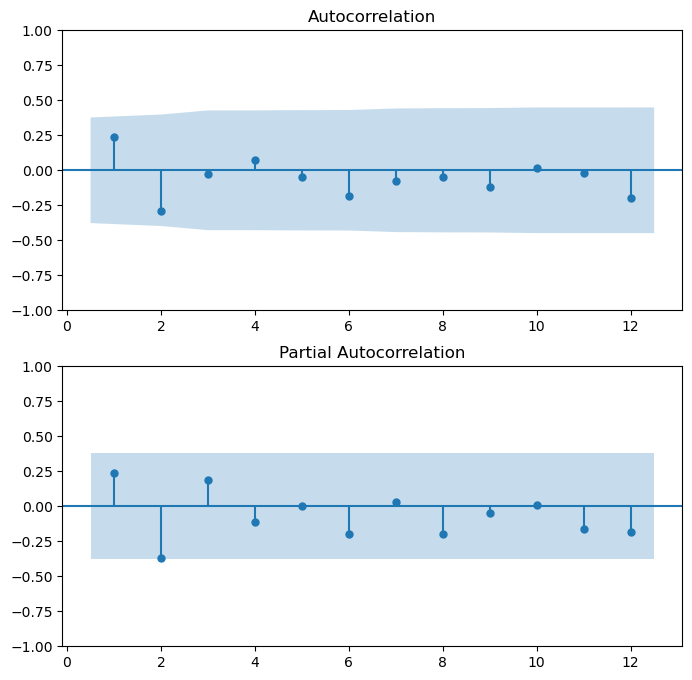

In [1101]:
# plot ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(train, lags=12, zero=False, ax=ax1)
plot_pacf(train, lags=12, zero=False, ax=ax2)
plt.show()

&emsp;The ACF and PACF plots both did do not show signs of tailing off. The determination of orders is inconclusive.

In [1102]:
# Search for the best order by AIC and BIC
order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(train, order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

In [1103]:
order_df.sort_values(['aic', 'bic'])

,p,q,aic,bic
2,0,2,202.898234,208.081582
6,1,1,203.421178,208.604525
1,0,1,203.814585,207.702096
7,1,2,204.666933,211.146117
14,2,4,204.809680,215.176375
3,0,3,204.873446,211.352631
10,2,0,204.891188,210.074535
11,2,1,205.029285,211.508469
12,2,2,205.144926,212.919947
8,1,3,205.388173,213.163194


&emsp;The order (0,0,2) yields the best AIC value.

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   27
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 -97.449
Date:                Thu, 26 Dec 2024   AIC                            202.898
Time:                        18:50:01   BIC                            208.082
Sample:                    01-31-2022   HQIC                           204.440
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.8529      2.023     91.391      0.000     180.889     188.817
ma.L1          0.5455     93.915      0.006      0.995    -183.525     184.616
ma.L2         -0.4543     42.674     -0.011      0.9

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


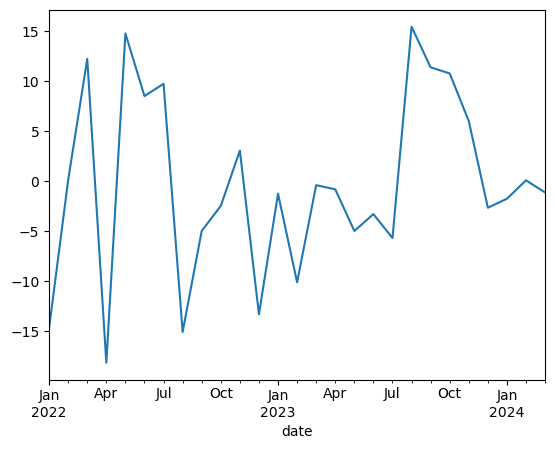

MAE:7.1450341569059965


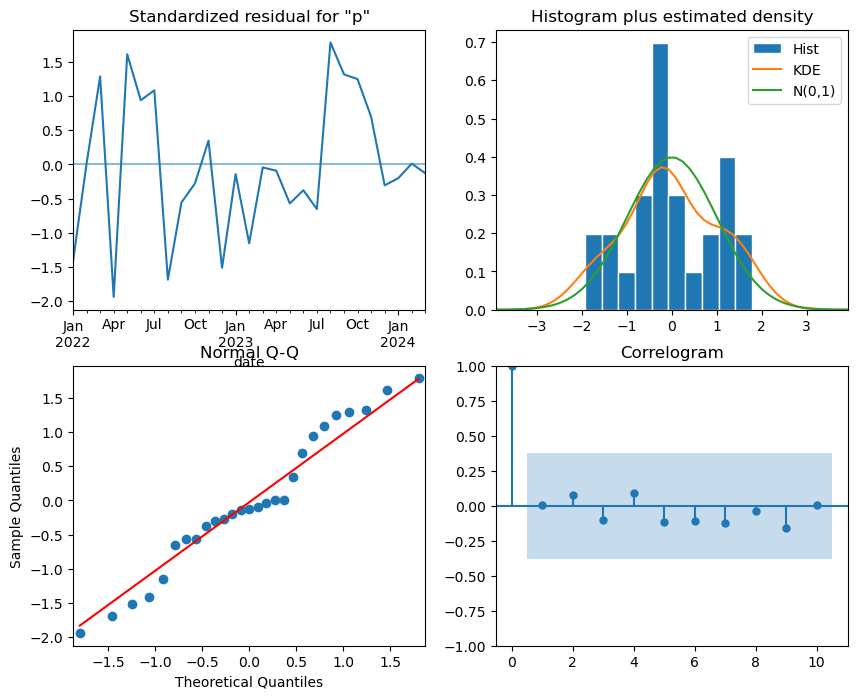

count    27.000000
mean     -0.300741
std       9.261534
min     -18.147397
25%      -4.960989
50%      -1.110728
75%       7.285796
max      15.475844
dtype: float64


In [1104]:
# Fit model
model = ARIMA(train, order=(0,0,2))
results = model.fit()
# Summary of fit model
print(results.summary())
# Line plot of residuals
residuals = results.resid
residuals.plot()
plt.show()
# Mean absolute error (MAE)
mae = np.mean(np.abs(residuals))
print(f'MAE:{mae}')
# Density plot of residuals - white Gaussian noise should be centred around 0
results.plot_diagnostics(figsize=(10,8))
plt.show()
# Summary stats of residuals
print(residuals.describe())

&emsp;The points on the Normal Q-Q plot do not lie along the red line. The model needs to improve.

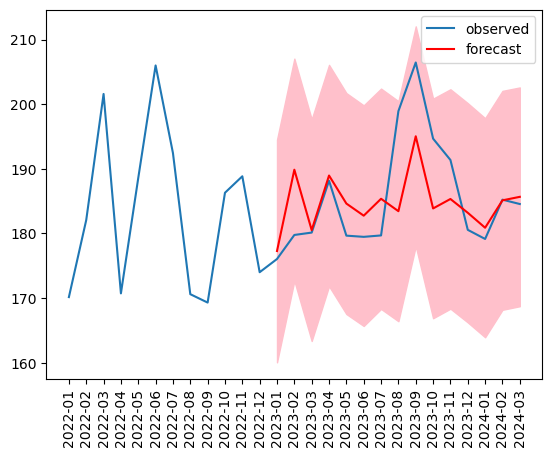

In [1105]:
# Forecast (one-step ahead in-sample prediction)
forecast = results.get_prediction(start=-15)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(train.index.to_series().astype('str'), train, label='observed')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis tick labels
plt.xticks(rotation=90)
plt.legend()
plt.show()

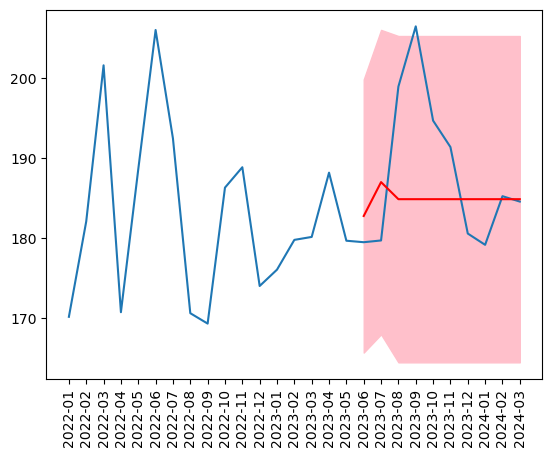

In [1106]:
# Forecast (Dynamic in-sample prediction)
forecast = results.get_prediction(start=-10, dynamic=True) # start=-25
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(train.index.to_series().astype('str'), train)
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis tick labels
plt.xticks(rotation=90)
plt.show()

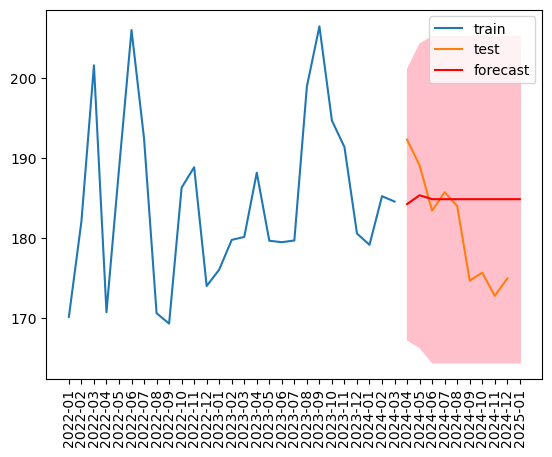

In [1107]:
# Forecast (Out-sample prediction)
forecast = results.get_forecast(steps=10)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(train.index.to_series().astype('str'), train, label='train')
plt.plot(test.index.to_series().astype('str'), test, label='test')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(rotation=90)
plt.legend()
plt.show()

&emsp;Only the one step ahead in-sample prediction is able to predict relatively accurately than dynamic in-sample and forecast. Without the information from the previous data point, the model failed to make useful predictions. In the following, I try to put seasonal pattern consideration into the model to account for the repeatedly spikes.

### Seasonal Pattern

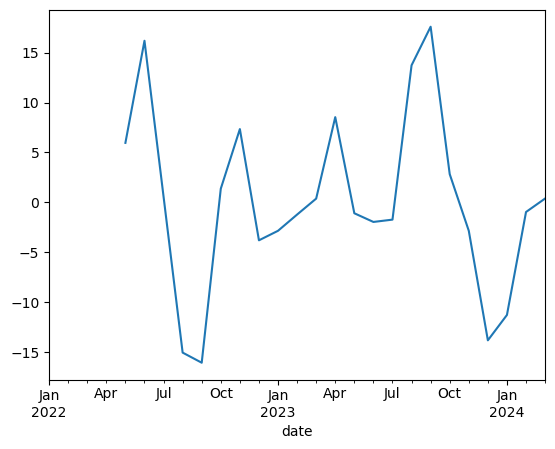

In [1108]:
# De-trend the time-series to determine the cycle period
df_detrend = train - train.rolling(5).mean()
df_detrend.dropna()
df_detrend.plot()
plt.show()

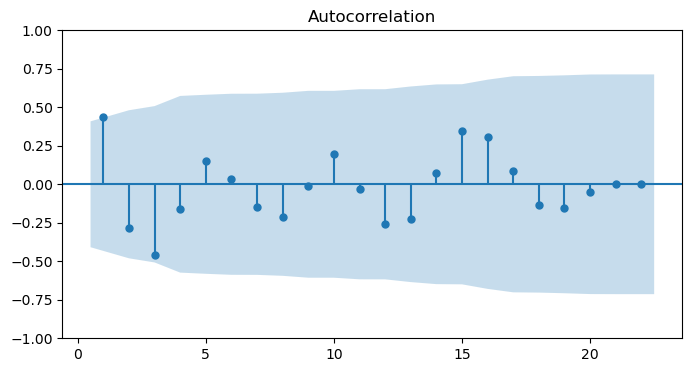

In [1109]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(df_detrend.dropna(), lags=22, zero=False, ax=ax) # lags=67
plt.show()

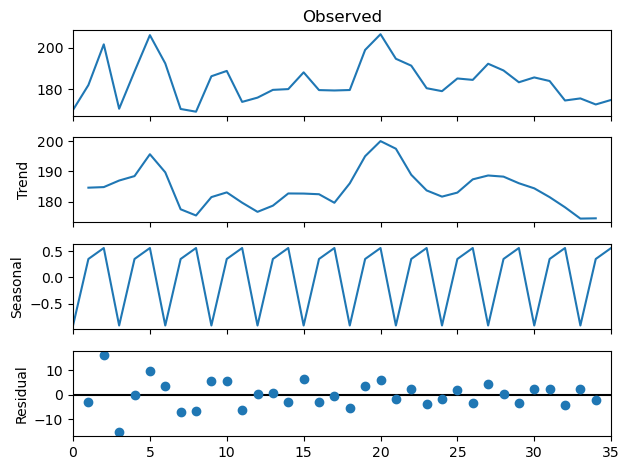

In [1110]:
decomp_results = seasonal_decompose(df_uni.values, period=3) # period=4
decomp_results.plot()
plt.show()

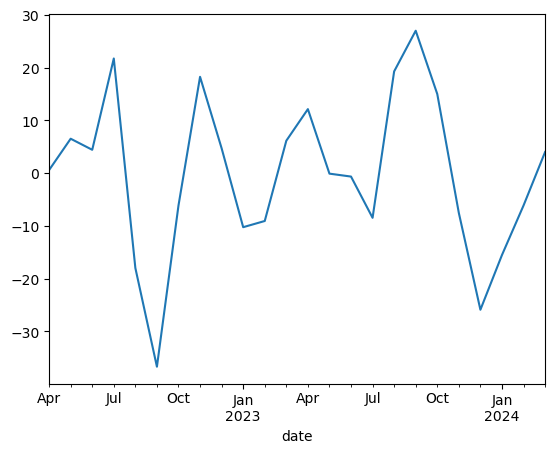

In [1111]:
# Seasonal differencing 
df_uni_season_diff = train.diff(3).dropna() # .diff(4)
df_uni_season_diff.plot()
plt.show()

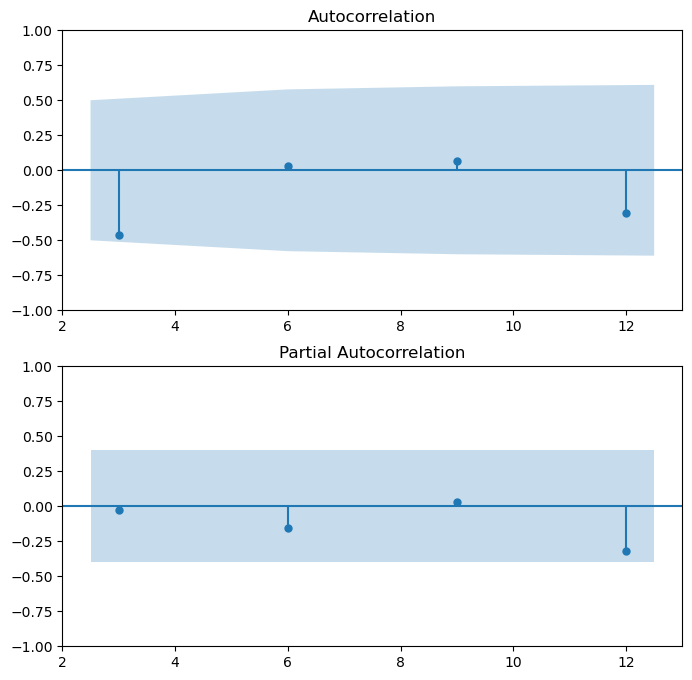

In [1112]:
# plot seasonal ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
lags = [i for i in range(3,13,3)]
plot_acf(df_uni_season_diff, lags=lags, ax=ax1)
plot_pacf(df_uni_season_diff, lags=lags, ax=ax2)
plt.show()

&emsp;The ACF and PACF again do not show any tailing off. The orders are still inconclusive.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50318D+00    |proj g|=  5.27446D-02

At iterate    5    f=  3.49360D+00    |proj g|=  9.01408D-04

At iterate   10    f=  3.49306D+00    |proj g|=  3.38258D-04

At iterate   15    f=  3.49302D+00    |proj g|=  1.27295D-04

At iterate   20    f=  3.49301D+00    |proj g|=  2.96555D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   7.725D-06   3.493D+00
  F =   3.4930145687493503     

CONVERG

 This problem is unconstrained.


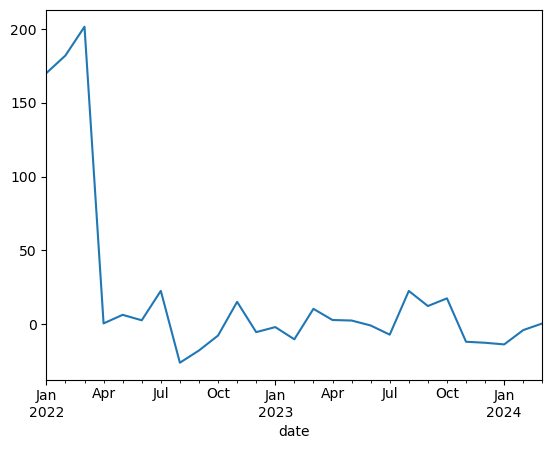

MAE:29.219025770812955


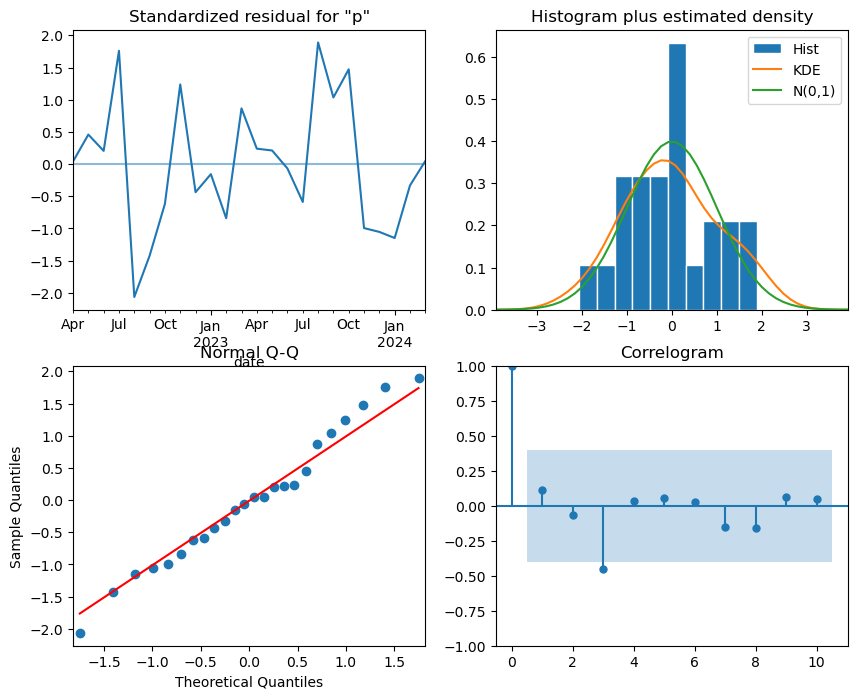

count     27.000000
mean      20.426905
std       60.477595
min      -26.051588
25%       -7.337556
50%        0.576669
75%       13.779453
max      201.579011
dtype: float64


In [1113]:
# Apply SARIMA to capture seasonal patterns
model = SARIMAX(train, order=(0,0,2), seasonal_order=(0,1,0,3))
results = model.fit()

# summary of fit model
print(results.summary())
# line plot of residuals
residuals = results.resid
residuals.plot()
plt.show()
# Mean absolute error (MAE)
mae = np.mean(np.abs(residuals))
print(f'MAE:{mae}')
# density plot of residuals - white Gaussian noise should be centred around 0
results.plot_diagnostics(figsize=(10,8))
plt.show()
# residuals.plot(kind='kde')
# plt.show()
# summary stats of residuals
print(residuals.describe())

&emsp;pmdarima estimator is used to find the best orders with given orders of differencing for both non-seasonal and seasonal patterns with a period of 3.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[3] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=202.010, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=198.029, Time=0.01 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=200.014, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=200.655, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=198.430, Time=0.04 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[3] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=198.886, Time=0.06 sec
 ARIMA(0,0,0)(1,1,0)[3] intercept   : AIC=198.532, Time=0.01 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=194.283, Time=0.03 sec
 ARIMA(2,0,0)(0,1,0)[3] intercept   : AIC=192.420, Time=0.02 sec
 ARIMA(2,0,0)(0,1,1)[3] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.08 sec
 ARIMA

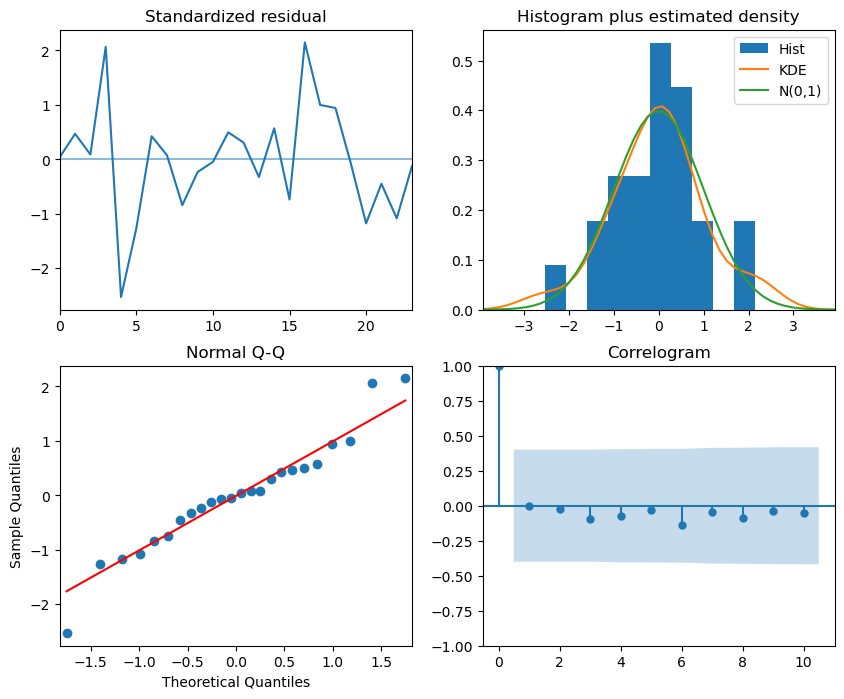

MAE: 27.72767496932352


['model.pkl']

In [1114]:
# Searching over model orders
results = pm.auto_arima(train.values, seasonal=True, d=0, D=1, m=3, information_criterion='aic', trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
# Update parameters with new observations
# results.update(df_new)
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

print(f'MAE: {np.mean(np.abs(results.resid()))}')

joblib.dump(results, "model.pkl")

# Load model
# model_results_object = joblib.load("model.pkl")

&emsp;The mean absolute error reduced and the data points after 0 in correlogram are all insignificant. Additionally, the histogram has a better distribution that resembles the normal one.

In [1115]:
results

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 3),
      suppress_warnings=True, with_intercept=False)

In [1117]:
# Apply SARIMA to capture seasonal patterns
model = SARIMAX(train, order=(2,0,0), seasonal_order=(0,1,0,3))
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41802D+00    |proj g|=  3.24438D-02

At iterate    5    f=  3.41591D+00    |proj g|=  1.04016D-02

At iterate   10    f=  3.41536D+00    |proj g|=  2.09082D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   2.091D-06   3.415D+00
  F =   3.4153581034303175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


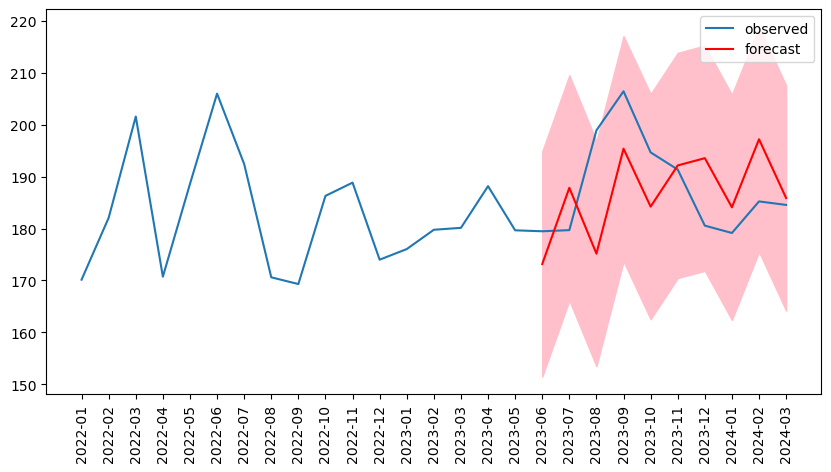

In [1121]:
# Forecast (one-step ahead in-sample prediction)
forecast = results.get_prediction(start=-10)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(train.index.to_series().astype('str'), train, label='observed')
# plt.plot(train.index.to_series().astype('str'), train, label='validate')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(rotation=90)
plt.legend()
plt.show()

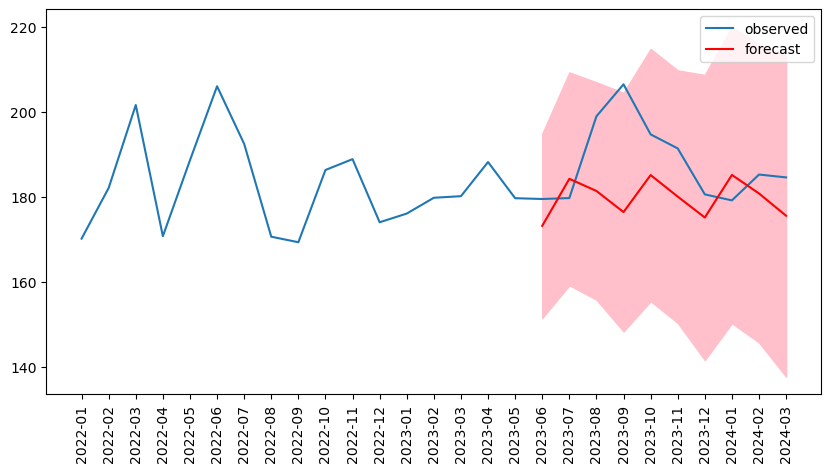

In [1122]:
# Forecast (Dynamic in-sample prediction)
forecast = results.get_prediction(start=-10, dynamic=True)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(train.index.to_series().astype('str'), train, label='observed')
# plt.plot(test.index.to_series().astype('str'), test, label='validate')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(rotation=90)
plt.legend()
plt.show()

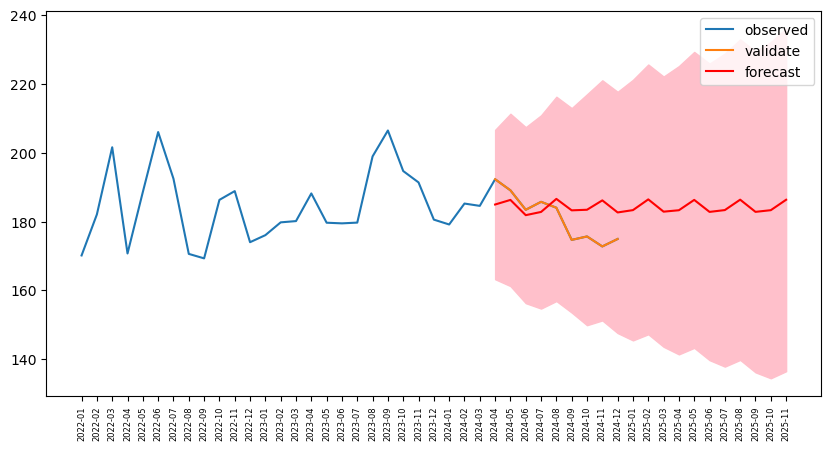

In [1123]:
# Forecast (Out-sample prediction)
forecast = results.get_forecast(steps=20)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_uni.index.to_series().astype('str'), df_uni, label='observed')
plt.plot(test.index.to_series().astype('str'), test, label='validate')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.show()

&emsp;The seasonal model is unable to predict accurately the regional trend. Next, an exogenous feature is put into the training model.

## Exogenous Feature<a id='exog'></a>

In [976]:
# Connect database for weather data
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password"
)
mycursor = mydb.cursor()

# Extract dataset
mycursor.execute(
    "SELECT CONCAT(year, '-', month) AS month, ROUND(AVG(temp_max), 1) AS temp_max\
    FROM base.weather\
    WHERE year >= 2019\
    GROUP BY year, month\
    LIMIT 5"
)

result = mycursor.fetchall()

for x in result:
    print(x)

('2019-01', 30.5)
('2019-02', 31.3)
('2019-03', 30.1)
('2019-04', 25.6)
('2019-05', 22.2)
